In [1]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
 

def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn, engine = None, None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            
            engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                user, password, host, port, database
            ))
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return [conn, engine]


In [2]:
[conn, engine] = connect_postgres()

INFO:root:Connected...
INFO:root:Everything goes well from Postgres, you're a fu*** pro...


In [3]:
df_iss = pd.read_sql("""
SELECT
	copytransaction.id, title_name, code, trans_copy_code_id, trans_tittle_code_id, trans_date_id as date_iss
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date, public.title
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3743' AND
	trans_type_code IN ('ISS') AND
    trans_tittle_code_id = title.id AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, id, title_name

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df_ret = pd.read_sql("""
SELECT
    trans_copy_code_id, trans_tittle_code_id, title_name, code, trans_date_id as date_ret
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date, public.title
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3743' AND
	trans_type_code IN ('RET') AND
    trans_tittle_code_id = title.id AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, copy.id, title_name

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df_iss = df_iss.reset_index(drop=True)
df_iss

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss
0,39355,Competitive strategy,199120033,16331,10188,19990303
1,293269,Biología general,199120033,131785,99376,19990525
2,220902,Colombia: Analisis al futuro,199120033,184745,138918,19971112
3,187137,Investigación de operaciones en la ciencia adm...,199120033,185454,139509,19971009
4,581499,Investigación de operaciones en la ciencia adm...,199120033,185457,139509,19970820
...,...,...,...,...,...,...
44908,8802899,Precálculo,201830743,706973,705983,20180207
44909,8938708,The purge,201830957,916536,928536,20180207
44910,8764935,Game of thrones,201830990,804796,823917,20180224
44911,8919499,The imitation game [videograbación],201830990,873790,889459,20180220


In [6]:
df_ret = df_ret.reset_index(drop=True)
df_ret

,trans_copy_code_id,trans_tittle_code_id,title_name,code,date_ret
0,16331,10188,Competitive strategy,199120033,19990318
1,131785,99376,Biología general,199120033,19990526
2,184745,138918,Colombia: Analisis al futuro,199120033,19971114
3,185454,139509,Investigación de operaciones en la ciencia adm...,199120033,19971023
4,185457,139509,Investigación de operaciones en la ciencia adm...,199120033,19970919
...,...,...,...,...,...
45085,706973,705983,Precálculo,201830743,20180209
45086,916536,928536,The purge,201830957,20180207
45087,804796,823917,Game of thrones,201830990,20180224
45088,873790,889459,The imitation game [videograbación],201830990,20180220


In [7]:
df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('int64').columns})
df_iss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44913 entries, 0 to 44912
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    44913 non-null  int32 
 1   title_name            44913 non-null  object
 2   code                  44913 non-null  int32 
 3   trans_copy_code_id    44913 non-null  int32 
 4   trans_tittle_code_id  44913 non-null  int32 
 5   date_iss              44913 non-null  int32 
dtypes: int32(5), object(1)
memory usage: 1.2+ MB


In [8]:
df_ret = df_ret.astype({col: 'int32' for col in df_ret.select_dtypes('int64').columns})
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45090 entries, 0 to 45089
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   trans_copy_code_id    45090 non-null  int32 
 1   trans_tittle_code_id  45090 non-null  int32 
 2   title_name            45090 non-null  object
 3   code                  45090 non-null  int32 
 4   date_ret              45090 non-null  int32 
dtypes: int32(4), object(1)
memory usage: 1.0+ MB


In [9]:
df = df_iss.merge(df_ret, how='left', on=['code','trans_copy_code_id', 'trans_tittle_code_id', 'title_name'])
df['diff'] = df['date_ret'] - df['date_iss']
df = df[df['diff'] >= 0]
df = df.sort_values(
    ['trans_tittle_code_id', 'diff']
)
df

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff
1239,5865695,Bases de datos e implementacion mediante DMS II,199218080,130217,24,19970424,19970424.0,0.0
10121,15054,Bases de datos e implementacion mediante DMS II,199428238,26,24,19990217,19990217.0,0.0
8889,518380,Bases de datos e implementacion mediante DMS II,199344105,130217,24,19970611,19970627.0,16.0
8403,5970129,Introduccion a la teoria general de los sistemas,199342359,30,25,20011116,20011116.0,0.0
31921,1895233,Introduccion a la teoria general de los sistemas,200333579,30,25,20040818,20040827.0,9.0
...,...,...,...,...,...,...,...,...
77806,8956782,El aliento de los dioses,201367667,911101,926149,20171108,20171207.0,99.0
89004,9117074,The purge,201827246,916536,928536,20180207,20180207.0,0.0
89015,8938708,The purge,201830957,916536,928536,20180207,20180207.0,0.0
83267,8895215,Satanás,201523548,912916,928592,20180126,20180219.0,93.0


In [10]:
df.columns

Index(['id', 'title_name', 'code', 'trans_copy_code_id',
       'trans_tittle_code_id', 'date_iss', 'date_ret', 'diff'],
      dtype='object')

In [11]:
df['ISS'] = pd.to_datetime(df['date_iss'].astype(str), format='%Y%m%d') 
df['RET'] = pd.to_datetime(df['date_ret'].astype(str), format='%Y%m%d')
df['trans_copy_code_id'] = df['trans_copy_code_id'].astype(str)
df['trans_tittle_code_id'] = df['trans_tittle_code_id'].astype(str)
df['duration'] = df['RET'] - df['ISS'] + pd.Timedelta(days=1)
df['duration'] = df['duration'].dt.days
df

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff,ISS,RET,duration
1239,5865695,Bases de datos e implementacion mediante DMS II,199218080,130217,24,19970424,19970424.0,0.0,1997-04-24,1997-04-24,1
10121,15054,Bases de datos e implementacion mediante DMS II,199428238,26,24,19990217,19990217.0,0.0,1999-02-17,1999-02-17,1
8889,518380,Bases de datos e implementacion mediante DMS II,199344105,130217,24,19970611,19970627.0,16.0,1997-06-11,1997-06-27,17
8403,5970129,Introduccion a la teoria general de los sistemas,199342359,30,25,20011116,20011116.0,0.0,2001-11-16,2001-11-16,1
31921,1895233,Introduccion a la teoria general de los sistemas,200333579,30,25,20040818,20040827.0,9.0,2004-08-18,2004-08-27,10
...,...,...,...,...,...,...,...,...,...,...,...
77806,8956782,El aliento de los dioses,201367667,911101,926149,20171108,20171207.0,99.0,2017-11-08,2017-12-07,30
89004,9117074,The purge,201827246,916536,928536,20180207,20180207.0,0.0,2018-02-07,2018-02-07,1
89015,8938708,The purge,201830957,916536,928536,20180207,20180207.0,0.0,2018-02-07,2018-02-07,1
83267,8895215,Satanás,201523548,912916,928592,20180126,20180219.0,93.0,2018-01-26,2018-02-19,25


In [12]:
df.describe()

,id,code,date_iss,date_ret,diff,duration
count,6.797500e+04,6.797500e+04,6.797500e+04,6.797500e+04,67975.000000,67975.000000
mean,4.128171e+06,2.005426e+08,2.007037e+07,2.007229e+07,1918.701302,72.175167
std,2.728040e+06,7.515092e+05,6.107222e+04,6.134510e+04,7566.480083,266.223212
min,9.180000e+02,1.991200e+08,1.997033e+07,1.997033e+07,0.000000,1.000000
25%,1.500654e+06,1.998342e+08,2.002021e+07,2.002052e+07,0.000000,1.000000
50%,4.166130e+06,2.007409e+08,2.007102e+07,2.008022e+07,6.000000,6.000000
75%,6.386844e+06,2.011295e+08,2.012091e+07,2.012102e+07,105.000000,34.000000
max,9.222366e+06,2.018707e+08,2.018032e+07,2.018033e+07,159203.000000,5606.000000


In [13]:
df = df[df['duration'] <= 100].sort_values('duration')

In [14]:
df_titles = df[['trans_tittle_code_id', 'title_name']]
df_titles = df_titles.set_index('trans_tittle_code_id')
df_titles

,title_name
trans_tittle_code_id,
24,Bases de datos e implementacion mediante DMS II
541327,Como programar en Java
541327,Como programar en Java
541327,Como programar en Java
541327,Como programar en Java
...,...
633795,Matemática discreta y sus aplicaciones
19670,Mitologia nordica
796341,Enciclopedia de Microsoft Visual C#


In [15]:
df_new = df.drop(['code', 'trans_copy_code_id', 'date_iss', 'id', 'date_ret', 'diff', 'ISS', 'RET'], axis=1)
df_new = df_new.groupby(['trans_tittle_code_id'])['duration'].agg(
    borrow_days='sum',
    borrow_numbers='count',
).sort_values(
    ['borrow_days', 'borrow_numbers']
).reset_index()
df_new['score'] = df_new['borrow_days'] * df_new['borrow_numbers']
df_new = df_new.set_index('trans_tittle_code_id')
# df_new = df_new.loc[(df_new['borrow_days']  <= 10950)] # past 30 years
df_new

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
10019,1,1,1
100191,1,1,1
100453,1,1,1
100493,1,1,1
100832,1,1,1
...,...,...,...
604957,10492,516,5413872
430970,13622,641,8731702
686887,14415,626,9023790


In [16]:
df_new.describe()

,borrow_days,borrow_numbers,score
count,11480.000000,11480.000000,1.148000e+04
mean,76.485976,5.218728,1.724117e+04
std,573.331872,32.544428,8.198796e+05
min,1.000000,1.000000,1.000000e+00
25%,3.000000,1.000000,4.000000e+00
50%,16.000000,1.000000,1.800000e+01
75%,44.000000,2.000000,6.800000e+01
max,42501.000000,1975.000000,8.393948e+07


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

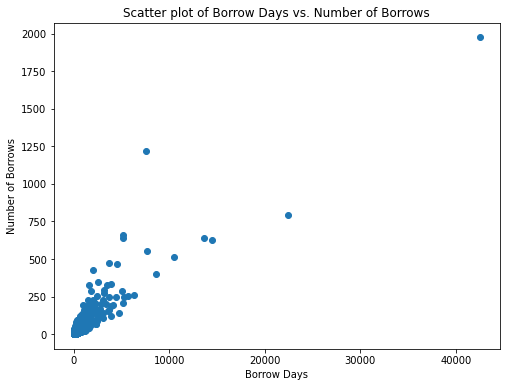

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(df_new.borrow_days, df_new.borrow_numbers)
plt.xlabel('Borrow Days')
plt.ylabel('Number of Borrows')
plt.title('Scatter plot of Borrow Days vs. Number of Borrows')
plt.show()

In [19]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

columns = df_new.columns
data_to_standardize = df_new[columns]
scaler = StandardScaler().fit(data_to_standardize)

# Standardize the columns.
standardized_data = df_new.copy()
standardized_columns = scaler.transform(data_to_standardize)
standardized_data[columns] = standardized_columns

standardized_data

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
10019,-0.131668,-0.129635,-0.021029
100191,-0.131668,-0.129635,-0.021029
100453,-0.131668,-0.129635,-0.021029
100493,-0.131668,-0.129635,-0.021029
100832,-0.131668,-0.129635,-0.021029
...,...,...,...
604957,18.167432,15.695575,6.582511
430970,23.626986,19.536646,10.629415
686887,25.010189,19.075717,10.985688


In [20]:
standardized_data.describe()

,borrow_days,borrow_numbers,score
count,1.148000e+04,1.148000e+04,11480.000000
mean,9.903035e-18,-9.903035e-18,0.000000
std,1.000044e+00,1.000044e+00,1.000044
min,-1.316677e-01,-1.296355e-01,-0.021029
25%,-1.281791e-01,-1.296355e-01,-0.021025
50%,-1.055037e-01,-1.296355e-01,-0.021008
75%,-5.666420e-02,-9.890690e-02,-0.020947
max,7.399966e+01,6.052855e+01,102.363679


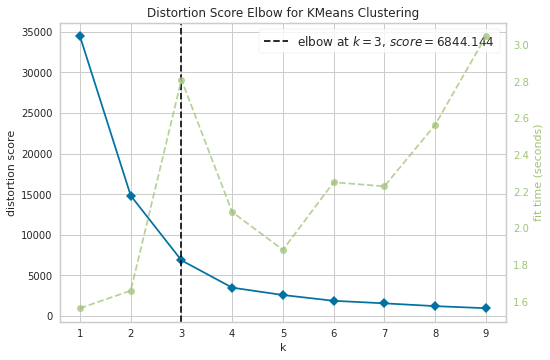

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(init='k-means++', random_state=540)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(standardized_data)
visualizer.show()

In [22]:
# Train a Kmeans instance
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=540)
kmeans.fit(standardized_data)
clusters = kmeans.predict(standardized_data)
df_new['cluster'] = clusters


df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('int64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('float64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('bool').columns})

df_new

,borrow_days,borrow_numbers,score,cluster
trans_tittle_code_id,,,,
10019,1,1,1,0
100191,1,1,1,0
100453,1,1,1,0
100493,1,1,1,0
100832,1,1,1,0
...,...,...,...,...
604957,10492,516,5413872,2
430970,13622,641,8731702,2
686887,14415,626,9023790,2


In [23]:
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

pca = PCA(n_components=2)

reduced_X = pd.DataFrame(pca.fit_transform(standardized_data), columns=["PC1", "PC2"])
reduced_X

,PC1,PC2
0,-0.164976,0.080687
1,-0.164976,0.080687
2,-0.164976,0.080687
3,-0.164976,0.080687
4,-0.164976,0.080687
...,...,...
11475,23.563857,-6.924773
11476,31.299082,-6.863541
11477,32.063038,-6.465229
11478,49.296148,-3.131368


In [24]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.164976,0.080687,0
1,-0.164976,0.080687,0
2,-0.164976,0.080687,0
3,-0.164976,0.080687,0
4,-0.164976,0.080687,0
...,...,...,...
11475,23.563857,-6.924773,2
11476,31.299082,-6.863541,2
11477,32.063038,-6.465229,2
11478,49.296148,-3.131368,2


/opt/app/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


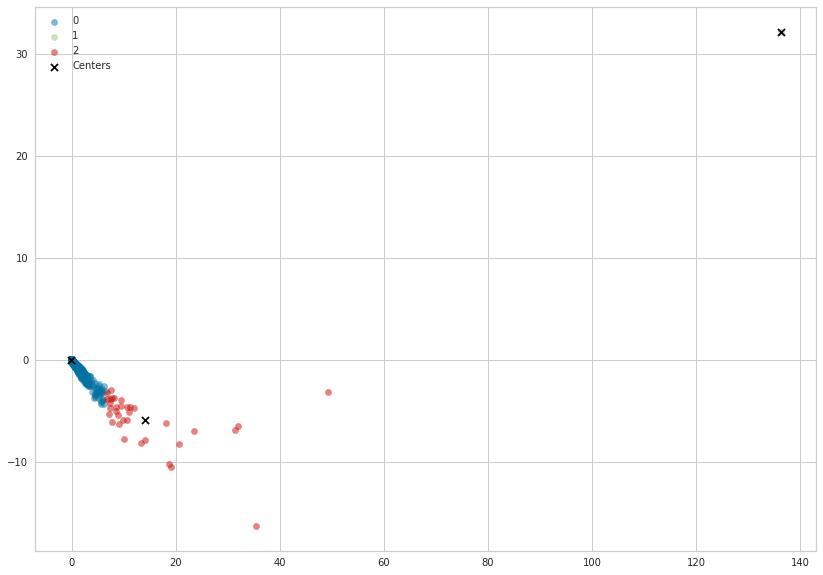

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

reduced_centers = pca.transform(kmeans.cluster_centers_)

for cluster in range(0, n_clusters):
    plt.scatter(
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC1'],
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC2'], 
        label=cluster, alpha=0.5, s=40
    )

plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='x', label='Centers', c="black", s=50)
plt.legend()
plt.show()

In [26]:
number_clusters = df_new['cluster'].value_counts()

In [27]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11480 entries, 10019 to 633795
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   borrow_days     11480 non-null  int32
 1   borrow_numbers  11480 non-null  int32
 2   score           11480 non-null  int32
 3   cluster         11480 non-null  int32
dtypes: int32(4)
memory usage: 527.1+ KB


In [28]:
df_final = pd.merge(
    df_new, df_titles, on=['trans_tittle_code_id']
).drop_duplicates()
df_final

,borrow_days,borrow_numbers,score,cluster,title_name
trans_tittle_code_id,,,,,
10019,1,1,1,0,Contaminacion atmosferica
100191,1,1,1,0,Fragmentos
100453,1,1,1,0,La guerra que viene
100493,1,1,1,0,Introductory circuit analysis
100832,1,1,1,0,Las aeronaves y sus materiales
...,...,...,...,...,...
604957,10492,516,5413872,2,Física para ciencias e ingeniería (v2)
430970,13622,641,8731702,2,Introduction to algorithms
686887,14415,626,9023790,2,Organización y arquitectura de computadores


In [29]:
df_final.describe()

,borrow_days,borrow_numbers,score,cluster
count,11382.000000,11382.000000,1.138200e+04,11382.000000
mean,77.076085,5.252504,1.738949e+04,0.006062
std,575.756565,32.682133,8.234004e+05,0.109548
min,1.000000,1.000000,1.000000e+00,0.000000
25%,3.000000,1.000000,4.000000e+00,0.000000
50%,16.000000,1.000000,1.800000e+01,0.000000
75%,44.000000,2.000000,6.900000e+01,0.000000
max,42501.000000,1975.000000,8.393948e+07,2.000000


In [30]:
cluster0 = df_final[df_final["cluster"] == 0].sort_values("score", ascending=False)
cluster1 = df_final[df_final["cluster"] == 1].sort_values("score", ascending=False)
cluster2 = df_final[df_final["cluster"] == 2].sort_values("score", ascending=False)

In [31]:
cluster0.describe()

,borrow_days,borrow_numbers,score,cluster
count,11347.000000,11347.000000,11347.000000,11347.0
mean,56.949766,3.957081,2150.605358,0.0
std,179.188332,12.732263,21024.251328,0.0
min,1.000000,1.000000,1.000000,0.0
25%,3.000000,1.000000,4.000000,0.0
50%,16.000000,1.000000,18.000000,0.0
75%,44.000000,2.000000,68.000000,0.0
max,3909.000000,228.000000,535295.000000,0.0


In [32]:
cluster1.describe()

,borrow_days,borrow_numbers,score,cluster
count,1.0,1.0,1.0,1.0
mean,42501.0,1975.0,83939475.0,1.0
std,NaN,NaN,NaN,NaN
min,42501.0,1975.0,83939475.0,1.0
25%,42501.0,1975.0,83939475.0,1.0
50%,42501.0,1975.0,83939475.0,1.0
75%,42501.0,1975.0,83939475.0,1.0
max,42501.0,1975.0,83939475.0,1.0


In [33]:
cluster2.describe()

,borrow_days,borrow_numbers,score,cluster
count,34.000000,34.000000,3.400000e+01,34.0
mean,5546.176471,379.647059,2.634848e+06,2.0
std,4217.882080,223.757022,3.620981e+06,0.0
min,1622.000000,140.000000,5.199480e+05,2.0
25%,3184.500000,246.000000,7.539450e+05,2.0
50%,4292.500000,289.500000,1.107338e+06,2.0
75%,5607.000000,472.500000,2.976402e+06,2.0
max,22392.000000,1217.000000,1.775686e+07,2.0


In [34]:
cluster0.head(20)

,borrow_days,borrow_numbers,score,cluster,title_name
trans_tittle_code_id,,,,,
542562,3545,151,535295,0,Inteligencia artificial
559092,3909,119,465171,0,How to design programs
100876,2039,228,464892,0,Electrónica digital
604537,2244,207,464508,0,Ingeniería de software
442585,2775,164,455100,0,Análisis y diseño de circuitos lógicos digitales
705048,2189,202,442178,0,Física para ciencias e ingeniería (v1)
785868,3045,140,426300,0,Discrete mathematics and its applications
541327,2619,161,421659,0,Como programar en Java
731804,2697,156,420732,0,Matemáticas discretas


In [35]:
cluster1.head(20)

,borrow_days,borrow_numbers,score,cluster,title_name
trans_tittle_code_id,,,,,
633795,42501,1975,83939475,1,Matemática discreta y sus aplicaciones


In [36]:
cluster2.head(20)

,borrow_days,borrow_numbers,score,cluster,title_name
trans_tittle_code_id,,,,,
559086,22392,793,17756856,2,Essentials of programming languages
548619,7567,1217,9209039,2,Cálculo con geometría analítica
686887,14415,626,9023790,2,Organización y arquitectura de computadores
430970,13622,641,8731702,2,Introduction to algorithms
604957,10492,516,5413872,2,Física para ciencias e ingeniería (v2)
584102,7692,555,4269060,2,Organización y arquitectura de computadores
115561,8632,399,3444168,2,Elementos de álgebra en ciencias de la computa...
358787,5148,658,3387384,2,Física (v2)
463593,5128,637,3266536,2,Física (v2)
